In [1]:
from statistics import stdev
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta
import vectorbt as vbt
import mplfinance as mpf
from datetime import datetime, timedelta,time
import warnings;   warnings.filterwarnings("ignore")

 <span style="font-size: 18 px;"> Data Source : Eightcap

<span style="font-size: 18 px;"> symbol : US30

<span style="font-size: 18 px;"> commission = 0 

<span style="font-size: 18 px;"> ไม่ได้คำนวนเกี่ยวกับ spread

In [2]:
import sys
sys.path.append( r'C:\Users\zig53\vscode_jupyther\Algo_Trading\Prop_firm\The5er%\algo_tools' )
from get_data_sqlite_mt5 import get_data_sqlite_mt5
data_3 = get_data_sqlite_mt5('US30').iloc[ :-1 ]

In [3]:
#convert mean price beetween bid-ask
for i in data_3.drop( ['spread' , 'tickvol'] , axis = 1).columns:
    data_3[ f'{i}' ] += data_3['spread']/100/2

## 1. Explore Data

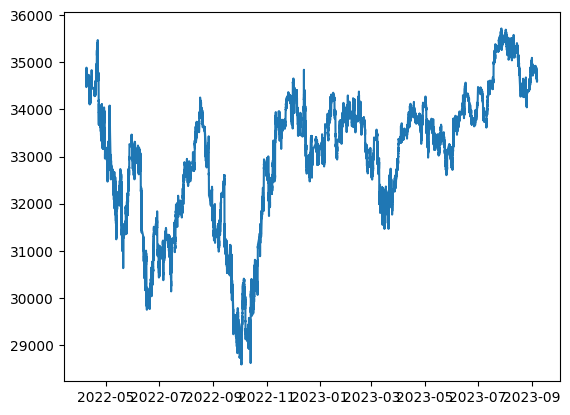

In [4]:
plt.plot( data_3['close'] )

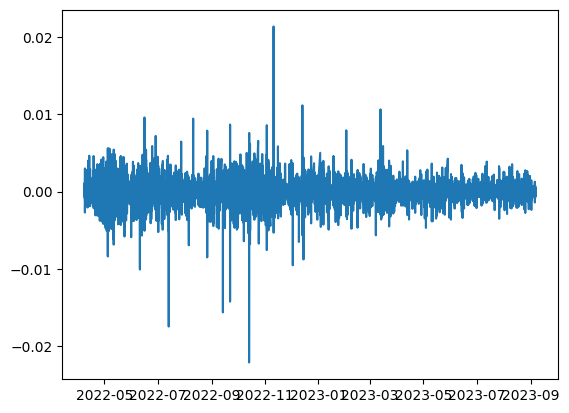

In [5]:
plt.plot( data_3['close'].pct_change() )

In [6]:
df = data_3.copy()
df['range'] = (df['high'] - df['low']) / vbt.pandas_ta('atr').run(df.high, df.low , df.close , length =  12 * 24 , mode = 'ema').atrr
df['price'] = df['open'].shift(-1)
df['stochd'] = ta.stoch( df['high'] , df['low'], df['close'] , 9, 3, 3, 'wma').iloc[ : , 1 ]

# # spreads
df['tickvol_sma_14'] = df['tickvol'].rolling(14).mean()
df['tickvol_sma_e'] =  df['tickvol'] / df['tickvol_sma_14']

df = df.dropna()

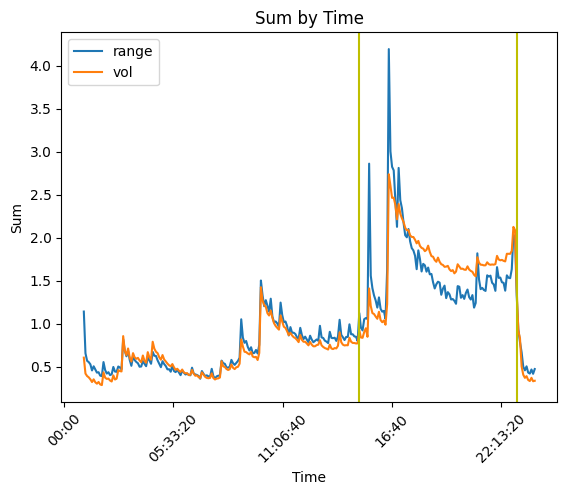

In [7]:
df['range'] = (df['high'] - df['low']) / vbt.pandas_ta('atr').run(df.high, df.low , df.close , length =  12 * 24 , mode = 'ema').atrr
df['vol'] =  df['tickvol'] / df['tickvol'].rolling(12*24).mean() 
grouped_data_vol =df.groupby(by = df.index.time)['vol'].mean()
grouped_data_range = df.groupby(by = df.index.time)['range'].mean()
sums_vol = grouped_data_vol#.values
sums_range = grouped_data_range#.values

sums_range.plot(title = 'range')
sums_vol.plot( title = 'vol')

plt.xlabel('Time')
plt.ylabel('Sum')
plt.title('Sum by Time')
plt.xticks(rotation=45)
plt.legend()  # Show legend with labels for each line
plt.axvline( x = '15:00:00' , color = 'y' )
plt.axvline( x = '23:00:00' , color = 'y' )
# Display the plot
plt.show()

 <span style="font-size: 18px;"> จากด้านบนจึงเลือกเทรดช่วงเวลา 15:00 ถึง 23:00 GMT+4

## 2. ส่องการกระจายของค่า indicator ต่างๆเทียบกับ return , ความผันผวน ในระยะเวลา X Bars ข้างหน้า

In [8]:
h_df = df.iloc[ : int(len(data_3)/2) ]

 tickvol_sma_e : 1.01908517922133 , 0.6817872789947008 , 1.3563830794479592 
 stochd : 50.994611096227636 , 24.491030332828764 , 77.4981918596265 


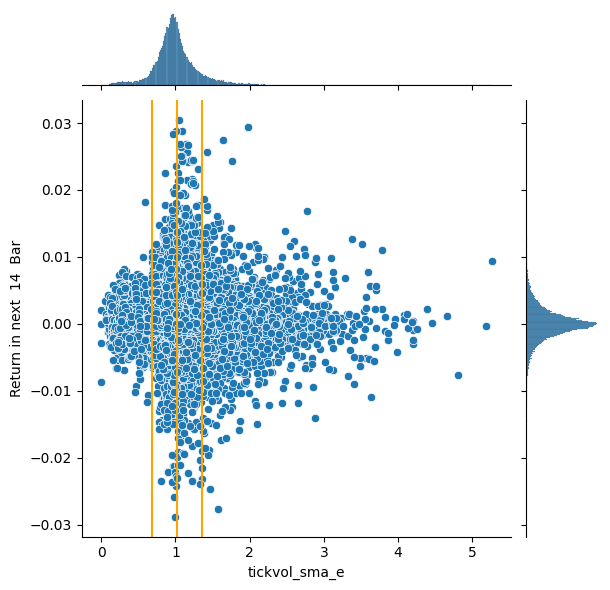

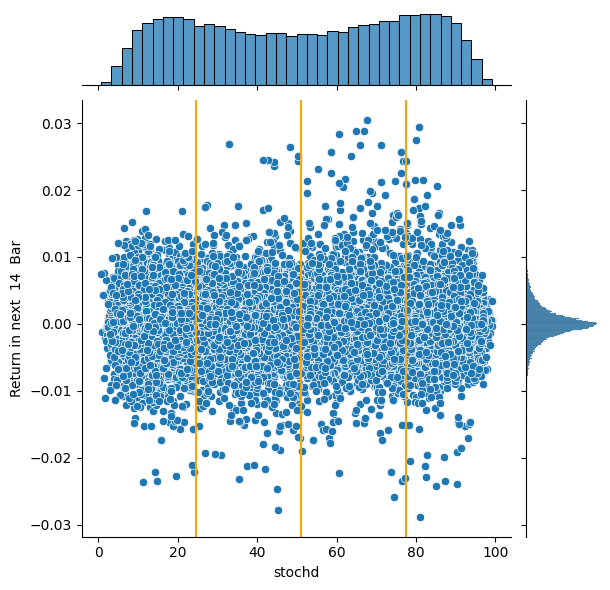

In [9]:
def indi_return ( df , ind = 'macd' ) :

    df['macd'] = vbt.pandas_ta('macd').run( df.close , 12  , 26 ).macd

    ret_14 = df['close'].pct_change( - 14 )
    indi = df[ f'{ind}' ]

    sns.jointplot( y = ret_14 , x = indi )

    mult = 1
    mea = indi.mean()
    sd_pos = indi.mean() - indi.std() * mult
    sd_neg = indi.mean() + indi.std() * mult
    plt.axvline( x = mea   , color = 'orange' )
    plt.axvline( x = sd_pos , color = 'orange' )
    plt.axvline( x = sd_neg  , color = 'orange' )
    plt.ylabel( f'Return in next  14  Bar' )
    print( f' {ind} : {mea} , {sd_pos} , { sd_neg } '  )
    
for i in [ 'tickvol_sma_e' , 'stochd' ] :
    indi_return( h_df , i )

 <span style="font-size: 18px;">เลือกใช้ filter tickvol_sma_e ช่วงประมาณ 0.9 - 1.3 เพราะ volume มีผลกับความผันผวน ไม่มากไม่น้อยจนเกินไป และเป็นช่วงที่มีกระจายหนาแน่น

 <span style="font-size: 18px;">stochd ช่วงที่มากกว่า 50 เพราะ เพราะมีบางช่วงที่ได้ return สูง

 price_vola : 0.9993615607006072 , 0.9981867355925476 , 1.0005363858086669 


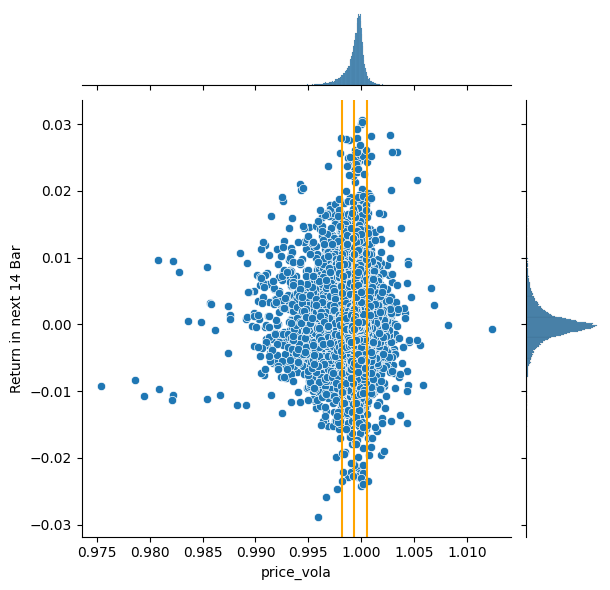

In [10]:
def indi_return ( df , ind = 'macd' ) :

    length = 14
    df['base'] = vbt.pandas_ta('wma').run( df['close']  , length = length ).wma
    df['sd'] = df['close'].rolling( length ).std()
    df['bbu'] = df['base'] + df['sd'] * 1
    df['bbl'] = df['base'] - df['sd'] * 1
    df = df[ df['close'] > df['bbl'] ]
    df['price_vola'] = (df['close'] / df['bbu'] )

    ret_14 = df['close'].pct_change( - length )
    indi = df[ f'{ind}' ]

    sns.jointplot( y = ret_14 , x = indi )

    mult = 1
    mea = indi.mean()
    sd_pos = indi.mean() - indi.std() * mult
    sd_neg = indi.mean() + indi.std() * mult
    plt.axvline( x = mea   , color = 'orange' )
    plt.axvline( x = sd_pos , color = 'orange' )
    plt.axvline( x = sd_neg  , color = 'orange' )
    plt.ylabel( f'Return in next {length} Bar' )
    print( f' {ind} : {mea} , {sd_pos} , { sd_neg } '  )

    
indi_return( h_df , 'price_vola' )

<span style="font-size: 18px;"> price_vola แสดงถึงราคาห่างจาก upper band เท่าไหร่

<span style="font-size: 18px;"> Entry ช่วงที่ 0.998 - 1.005 เพราะมีโอกาสได้ Return สูง การกระจายตัวหนาแน่น

<span style="font-size: 18px;">Exit ช่วงที่ 1.002 - 1.004 เพราะมีโอกาสที่จะได้ return ต่ำลงมาหลังจากนี้

<span style="font-size: 18px;" > หรือ Exit เมื่อหมดเวลา ( param's length * 5) นาที

<span style="font-size: 18px;"> ตั้ง stop loss ที่แนว lower band

In [11]:
import pandas as pd
import vectorbt as vbt
from datetime import timedelta,datetime
import numpy as np

def rsid(df,up,low,adx) :
    df = df.copy()
    df.loc[  ( df['price_vola'] >  0.998  ) & (df['price_vola'] <  1.0005 ) & ( df['close']/df['bbl'] > 1.0005  ), 'sig_2' ] = True
    df.loc[  ( df['price_vola'] >=  1.002 ) & ( df['price_vola'] <  1.004  ) , 'sig_2' ] = False
    return df['sig_2']

def pre_act(df):
    df = df.copy()
        
    traind_hours =  ((df['datetime'].dt.time >= datetime.strptime('15:00:00', '%H:%M:%S').time()) & ((df['datetime'].dt.time < datetime.strptime('23:00:00', '%H:%M:%S').time()))  )
    df.loc[  (df['sig_2'] == True) &  (df['sig_1'] == True) & traind_hours   ,'pre_action'  ] = True 
    df.loc[ (df['mn'] == True) &  (df['sig_2'] == False) ,'pre_action'] = False

    return df['pre_action']

def action(df):
    
    df = df.copy()
    df.loc[  (df['pre_action'] == True)  ,'action'  ] = True 
    df.loc[   (df['pre_action'] == False) ,'action'] = False

    return df['action']

def create_signal (data,bb_len = 14 ,std = 1 ,wr = 1 ,up = 80 ,low =20 ,adx_thres =21 ,direction='long'):

    df = data.copy(deep =  True).sort_index()
    df = df.reset_index()
    df['direction'] = direction
    df['open_shift'] = df['open'].shift(-1)
    df['price'] = df['open_shift']
    df = df[df['open_shift'].notnull()].sort_index()

    df['mn'] = (df['datetime'].dt.time == datetime.strptime('23:00:00', '%H:%M:%S').time() ) & (df['datetime'].dt.time.shift(1) == datetime.strptime('22:55:00', '%H:%M:%S').time() )


    df['base'] = vbt.pandas_ta('wma').run( df['close']  , length = bb_len ).wma
    df['sd'] = df['close'].rolling(bb_len).std()
    df['bbu'] = df['base'] + df['sd'] * std
    df['bbl'] = df['base'] - df['sd'] * std
    df['price_vola'] = df['close'] / ( df['bbu']  )

    ### All params set ###
    df['sig_1'] =   (df['tickvol_sma_e'] < 1.3  ) & (df['tickvol_sma_e'] > 0.9 ) & (df['stochd'] > 50 )

    #Sig2 compare previous rsi 
    df['sig_2'] = rsid(df,up,low,adx_thres)
    df['pre_action'] = pre_act(df)

    df['action'] = np.nan
    df['cut_price'] = np.nan
    df['take_profit'] = np.nan
    df['sig_3'] = np.nan
    df['position'] = 0

    pre_action = df['pre_action'].to_numpy()
    direction = df['direction'].to_numpy()
    sd = df['sd'].to_numpy()
    low = df['low'].to_numpy()
    high = df['high'].to_numpy()
    price = df['price'].to_numpy()
    spread = df['spread'].to_numpy()
    ent_time = df['datetime'].to_numpy()
    bbl = df['bbl'].to_numpy()

    action = np.full_like(pre_action, np.nan)
    cut_price = np.full_like(pre_action, np.nan)
    take_profit = np.full_like(pre_action, np.nan)
    sig_3 = np.full_like(pre_action, np.nan)
    position = np.zeros_like(pre_action)
    current_price = np.full_like(pre_action, np.nan)
    tbm = np.full_like(pre_action, np.nan)
    order_type = np.full_like(pre_action, np.nan)

    max_vola = np.full_like(pre_action, np.nan)

    for i in np.where(pre_action == True)[0]  :

        if (position[i] == 0) & ( action[i]  != False ):

            entry_time = ent_time[i]
            action[i] = True

            stop_losss = round( bbl[i]   , 2 )
            take_profitt = 0
            
            cut_price[i] = stop_losss
            take_profit[i] = take_profitt
            position[i] = 1

            for j in range(i+1, len(df) ) :
                
                position[j] = 1
                current_price[j] = ( price[j] - price[i] )

                if low[j] <= stop_losss:
                    action[j] = False
                    sig_3[j] = False
                    price[j] = stop_losss
                    tbm[i] = -1
                    order_type[j] = 'sl'
                    break
                    
                elif  ((pd.to_datetime(ent_time[j]) - pd.to_datetime(entry_time)) >= timedelta( minutes = int( bb_len )*5  ) ) | (pre_action[j] == False)     :
                    action[j] = False
                    sig_3[j] = True
                    tbm[i] = 0
                    order_type[j] = 'market'
                    break

            position[j] = 0

    df['action'] = action
    df['cut_price'] = cut_price
    df['take_profit'] = take_profit
    df['sig_3'] = sig_3
    df['position'] = position
    df['price'] = price
    df['cur_val'] = current_price
    df['tbm'] = tbm
    df['order_type'] = order_type
    df['max_vola'] = max_vola


    record = df.copy(deep = True)
    record = record.sort_values('datetime')
    record = record[record['action'].notnull()]
    record = record[record['cut_price'] != 0]
    record = record.loc[record['action'] != record['action'].shift(1)]   
    record.set_index('datetime', inplace = True)
    record['take_profit'] = record['take_profit'].ffill()
    record['cut_price'] = record['cut_price'].ffill()

    
    record['sig_3'] = record['sig_3'].fillna(True).sort_index()
    

    return [record, df]


In [12]:
def get_port( df , length , plot = False ):

  record  = create_signal( df , length )[0]

  portfolio = vbt.Portfolio.from_signals( record['price'] , 
                                entries = record['action'] == True ,
                                exits = record['action'] == False  ,
                              fees = 0.00 ,
                              slippage = 2.76810300606976e-05,
                                size = 0.05,
                                  size_type='amount'  )
  if plot  :                                   
    portfolio.plot().show()

  return portfolio

In [13]:
get_port( df , 14 , True )

In [14]:
def get_profit_factor( df, length ):
    
    record  = create_signal( df , length )[0]

    portfolio = get_port( df , length , plot = False  )
    
    return portfolio.stats()['Profit Factor']

<span style="font-size: 25px;"> Parameter Tuning

In [15]:
def params_tune( df ):
    tune_res = pd.DataFrame( )
    for i in range( 10 , 31  , 1 ):

        pf = get_profit_factor( df , i )
        
        tune_res = pd.concat( [ tune_res , pd.DataFrame( [ i  , pf ] ).T  ] )

    tune_res.columns = ['params' , 'Profit Factor' ]
    tune_res.reset_index( inplace = True , drop = True )
    return tune_res

score = params_tune( h_df  )

In [16]:
score.sort_values( 'Profit Factor' , ascending = False )

params  Profit Factor
13    23.0       1.190078
10    20.0       1.179619
12    22.0       1.176627
14    24.0       1.174629
16    26.0       1.162751
15    25.0       1.159602
11    21.0       1.150567
3     13.0       1.128556
7     17.0       1.124217
20    30.0       1.123729
17    27.0       1.123366
9     19.0       1.118014
4     14.0       1.117746
2     12.0       1.111291
19    29.0       1.110274
6     16.0       1.081754
0     10.0       1.080573
8     18.0       1.073234
18    28.0       1.073053
5     15.0       1.072967
1     11.0       1.030416

<span style="font-size: 18px;"> Forward Test /w Tuned parameter

In [17]:
# Forward Test
best_param = int(score.sort_values( 'Profit Factor' , ascending = False ).iloc[ 0 , 0])
f_df = df.loc[ h_df.index[-1] :  ]
pf = get_port( f_df , best_param , True )

In [18]:
pf.stats()

Start                         2022-12-22 21:10:00
End                           2023-09-05 22:25:00
Period                                       1428
Start Value                                 100.0
End Value                              111.032832
Total Return [%]                        11.032832
Benchmark Return [%]                     6.164335
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                         2.844244
Max Drawdown Duration                       253.0
Total Trades                                  714
Total Closed Trades                           714
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            37.535014
Best Trade [%]                           1.000497
Worst Trade [%]                         -0.628541
Avg Winning Trade [%]                    0.255072
Avg Losing Trade [%]                    -0.129365


In [19]:
rec = pf.exit_trades.records_readable
rec.head()

Exit Trade Id  Column      Size     Entry Timestamp  Avg Entry Price  \
0              0       0  0.003060 2022-12-22 21:10:00     32684.724722   
1              1       0  0.003047 2022-12-23 15:00:00     33097.086136   
2              2       0  0.003048 2022-12-23 17:20:00     33048.334787   
3              3       0  0.003047 2022-12-23 19:25:00     33147.087520   
4              4       0  0.003043 2022-12-23 21:30:00     33115.336641   

   Entry Fees      Exit Timestamp  Avg Exit Price  Exit Fees       PnL  \
0         0.0 2022-12-22 23:05:00    32964.907472        0.0  0.857228   
1         0.0 2022-12-23 15:30:00    33061.104809        0.0 -0.109646   
2         0.0 2022-12-23 19:15:00    33133.002819        0.0  0.258110   
3         0.0 2022-12-23 21:20:00    33072.504494        0.0 -0.227269   
4         0.0 2022-12-23 23:25:00    33151.002321        0.0  0.108540   

     Return Direction  Status  Position Id  
0  0.008572      Long  Closed            0  
1 -0.001087      Long  Closed            1  
2  0.002562      Long  Closed            2  
3 -0.002250      Long  Closed            3  
4  0.001077      Long  Closed            4

In [20]:
mu = (rec['Return']).mean()
sigma = (rec['Return']).std()

sim =  np.random.normal( loc = mu, scale = sigma , size = ( 300 , 10000 )   ) #(x,y) trade x times  , y scenario
sim =  pd.DataFrame(sim)
sim.iloc[ 0 , : ] = 0

returns_sim = (sim+1).cumprod()

returns_sim['percentile_5'] = np.percentile( returns_sim , 5 , axis = 1 )
returns_sim['percentile_95'] = np.percentile( returns_sim , 95 , axis = 1 )
returns_sim['min'] = np.min( returns_sim , axis = 1 )
returns_sim['max'] = np.max( returns_sim , axis = 1 )

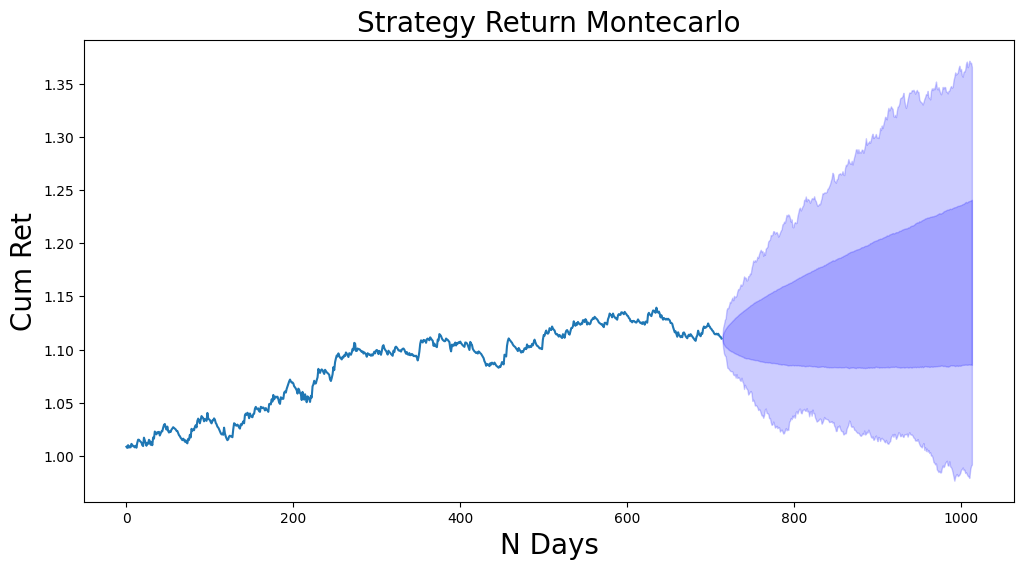

In [21]:
strat_cum_ret = ( rec['Return'] + 1 ).cumprod()
returns_sim_2 = returns_sim[['percentile_5'	, 'percentile_95'	, 'min'	,'max']]
cone  =  pd.concat( [strat_cum_ret , returns_sim_2 * strat_cum_ret.iloc[-1]] , ignore_index = True   )
plt.figure(  figsize=(12,6))
plt.plot( cone[0] )
plt.fill_between(  cone.index , cone['percentile_5'] , cone['percentile_95']  , color = 'blue'  , alpha = 0.2 )
plt.fill_between(  cone.index , cone['min'] , cone['max']  , color = 'blue'  , alpha = 0.2 )
plt.title( 'Strategy Return Montecarlo' , size = 20 )
plt.xlabel('N Days' , size = 20)
plt.ylabel('Cum Ret' , size  = 20)
plt.show()


In [22]:
dff = data_3.copy().dropna()
dada = rec.copy()

for i in dada.index :

    ent_time = dada.loc[ i , 'Entry Timestamp'] + timedelta( minutes = 5)
    ext_time = dada.loc[ i , 'Exit Timestamp']

    max_val = dff.loc[ ent_time : ext_time , 'high'].max()

    dada.loc[ i, 'max_val'] = max_val# - dada.loc[ i, 'Avg Entry Price']
    dada.loc[ i, 'max_val1'] =  dada.loc[ i, 'Avg Exit Price'] #- dada.loc[ i, 'Avg Entry Price']


In [23]:
dada = dada[ dada['Return'] > 0]

In [24]:
dada['sell_peak_range'] = dada['max_val'] - dada['max_val1']

<Axes: xlabel='sell_peak_range', ylabel='Density'>

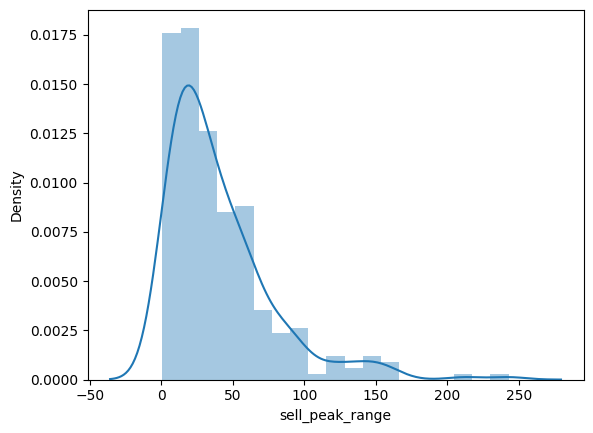

In [25]:
sns.distplot( dada['sell_peak_range'] )

<Axes: >

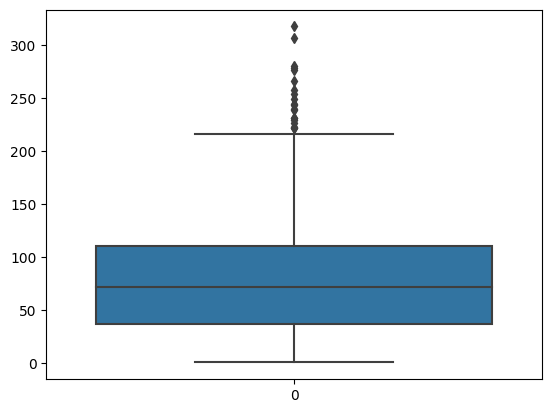

In [26]:
sns.boxplot( dada['Avg Exit Price'] - dada['Avg Entry Price'] )

<Axes: >

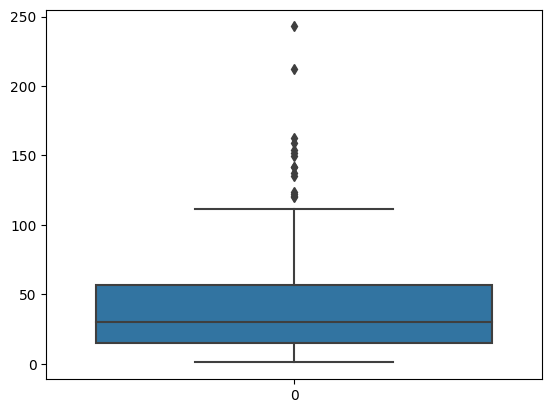

In [27]:
sns.boxplot( dada['sell_peak_range'] )

<span style="font-size: 15px;"> อาจจะต้องมีตั้ง take profit ในการระหว่างรันเทรนด้วย

# <u> วิเคราะห์กลยุทธ์ </u>

 <span style="font-size: 25px;"> มีข้อดี คือ สามารถทำกำไรได้ในช่วงนี้ที่ตลาดเป้น trend และมี momentum

<span style="font-size: 25px;"> ข้อเสีีย คือ ไม่สามารถรันเทรนได้ตามในช่วงที่ตลาดเป็นขาลง อาจจะต้องมาเล่น short บ้าง หรืออาจจะต้องมีตั้ง take profit เล่นในช่วงที่ตลาดเป็นจังหวะ rebound หรือความผันผวนสูง

<span style="font-size: 25px;"> และต้องมีการจำแนกสภาวะของตลาดเพื่อ design กลยุทธ์การเทรดให้เหมาะสมต่อไป